# Style transfer
Based on tutorial: https://keras.io/examples/generative/neural_style_transfer/

Paper: [https://arxiv.org/abs/1508.06576](A Neural Algorithm of Artistic Style)


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19
from IPython.display import Image, display
from csv import writer

Init Plugin
Init Graph Optimizer
Init Kernel


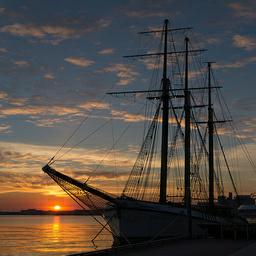

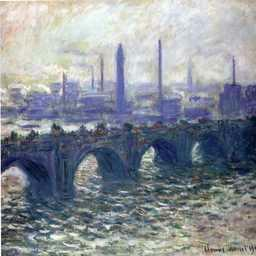

In [11]:
# Load images
base_name = "0aec1f9701.jpg"
style_name = "3b262c6726.jpg"

art_data_base_path = "../../data/art/"
base_image_path = art_data_base_path + "photo_jpg/" + base_name
style_reference_image_path = art_data_base_path + "monet_jpg/" + style_name

# GTA
#base_name = "Beverly_hills_example.jpg"
#style_name = "GTA5_street_style.jpg"
#art_data_base_path = "../../data/game/"
#base_image_path = art_data_base_path + base_name
#style_reference_image_path = art_data_base_path + style_name


# base_image_path = keras.utils.get_file("paris.jpg", "https://i.imgur.com/F28w3Ac.jpg")
# style_reference_image_path = keras.utils.get_file("starry_night.jpg", "https://i.imgur.com/9ooB60I.jpg")

result_prefix = base_name.split(".")[0] + "_generated"
# result_prefix = "paris_generated"

display(Image(base_image_path))
display(Image(style_reference_image_path))

In [5]:
# Parameters

# Weights of the loss components
total_variation_weight = 1e-6 # 1e-6
style_weight = 1e-6 # 1e-6
content_weight = 2.5e-8 #2.5e-8

# Dimension of the generated image. Set it to 400px here.
width, height = keras.preprocessing.image.load_img(base_image_path).size
img_nrows = 256 #400 / 256
img_ncols = int(width * img_nrows/ height)

# Preprocess image

In [6]:
# Open, resize and format pictures into tensors as required.
def preprocess_image(image_path):
    """
    Load an image into PIL format and resize to the target_size (nrows, ncols).
    """
    img = keras.preprocessing.image.load_img(image_path, target_size=(img_nrows, img_ncols))
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)


def decompress_image(x):
    """
    Converts a tensor into an image.
    """
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove ImageNet mean pixel value. Undoes a transformation defined
    # in vgg19.preprocess_input.
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # Convert from BGR to RGB.
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

# Compute the loss

In [7]:
# Gram matrix to calculate the correlation between different filter responses.

def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram


# Per layer loss
def style_loss(style, combination):
    s = gram_matrix(style)
    c = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols # N in the paper
    return tf.reduce_sum(tf.square(s - c)) / (4.0 * (channels ** 2) * (size ** 2))


def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))


# This loss keeps the image locally coherent.
def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a+b, 1.25))



In [8]:
# Computing the loss

# Layers used in the style loss.
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1"
]

# Layer used for the content loss.
content_layer_name = "block5_conv1"


def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]

    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )

    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss +=(style_weight / len(style_layer_names)) * sl
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

In [9]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

# Feature extraction model

In [12]:
model = vgg19.VGG19(weights="imagenet", include_top=False)

# Output for each layer by name.
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])


# Set up the model which returns the activation value for each layer in the outputs_dict.
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

In [13]:
feature_extractor.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

In [14]:
# Training loop
iterations = 1000
save_after_iterations = 200


optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate = 100.0, decay_steps=10, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % save_after_iterations == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = decompress_image(combination_image.numpy())
        fname = result_prefix + "_at_iteration_%d.png" % i
        keras.preprocessing.image.save_img("results/" + fname, img)

        # Log infos to runs.csv
        logs = [base_image_path, style_reference_image_path, i, style_layer_names, content_layer_name,total_variation_weight, style_weight, content_weight]
        with open("runs.csv", "a") as f:
            csv_writer = writer(f)
            #csv_writer.writerow([str(log) for log in logs])

2021-11-04 09:54:41.662605: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-04 09:54:41.667273: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-11-04 09:54:41.668257: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Iteration 200: loss=1018.42
Iteration 400: loss=902.04
Iteration 600: loss=867.90
Iteration 800: loss=854.84
Iteration 1000: loss=849.39


# Display results
display(Image(result_prefix + "_at_iteration_4000.png"))